### Investigation into safety cars
In this notebook I want to investigate safety cars. My main question is whether the amount of safety cars can be modelled by using a poisson distribution. In order to do this I need to do the following things

1. Find safety cars in the data\
   Hypothesis: A safety car can be found by the following things
        - Increasing laptimes
        - No overtaking
        - Smaller time-difference between first and last driver
2. Look at their distribution.
    Find Lambda (expected per time interval)
        Investigate lambda, are there differences per track? Or year?
3. Comment on this, was Austria 2020 so strange?
    


In [1]:
## Imports
import pandas as pd
import os
import numpy as np
import seaborn as sns
import random
from datetime import datetime
from sklearn.linear_model import LinearRegression

# To get full output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

#set random seed
random.seed(20)

In [2]:
# Change current working directory to where our F1 data is stored
os.getcwd();
os.chdir('C:\\Users\\yanni\\OneDrive\\Documents\\Data_Science\\F1_data')
os.getcwd()  

'c:\\Users\\yanni\\OneDrive\\Documents\\Data_Science'

'C:\\Users\\yanni\\OneDrive\\Documents\\Data_Science\\F1_data'

We want to have the laptimes per round, so we need the laptimes dataset. 

In [3]:
laptimes_df = pd.read_csv('lap_times.csv')

In [4]:
laptimes_df.head()
laptimes_df.shape
laptimes_df.dtypes
laptimes_df.describe(include = 'all')
laptimes_df.head()

,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342


(472504, 6)

raceId           int64
driverId         int64
lap              int64
position         int64
time            object
milliseconds     int64
dtype: object

,raceId,driverId,lap,position,time,milliseconds
count,472504.000000,472504.000000,472504.000000,472504.000000,472504,4.725040e+05
unique,NaN,NaN,NaN,NaN,70008,NaN
top,NaN,NaN,NaN,NaN,1:21.571,NaN
freq,NaN,NaN,NaN,NaN,36,NaN
mean,480.078222,229.773778,29.871804,9.651368,NaN,9.555486e+04
std,402.031351,345.382163,18.389696,5.562434,NaN,7.123219e+04
min,1.000000,1.000000,1.000000,1.000000,NaN,6.695700e+04
25%,112.000000,14.000000,14.000000,5.000000,NaN,8.223500e+04
50%,228.000000,30.000000,29.000000,9.000000,NaN,9.088100e+04
75%,911.000000,807.000000,44.000000,14.000000,NaN,1.026610e+05


,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342


#### Step 1. Find safetycars in the data
In order to find these in the data we have the following hypotheses
1. There are increasing laptimes
2. There is no overtaking
3. The time difference between the first and the last driver decreases

In [5]:
# Hypothesis 1. There are increasing laptimes
# Here we check the distribution of laptimes in a "normal" race
# I also want to know which race I'm looking at, so I'll add that info
races_df = pd.read_csv('races.csv')
races_df.head()
races_df.dtypes
races_df['race'] = races_df['name'] + ' ' + races_df['year'].astype(str)
races_df.head()

,raceId,year,round,circuitId,name,date,time,url
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_Grand_Prix
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Grand_Prix
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Grand_Prix
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Grand_Prix
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Grand_Prix


raceId        int64
year          int64
round         int64
circuitId     int64
name         object
date         object
time         object
url          object
dtype: object

,raceId,year,round,circuitId,name,date,time,url,race
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_Grand_Prix,Australian Grand Prix 2009
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Grand_Prix,Malaysian Grand Prix 2009
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Grand_Prix,Chinese Grand Prix 2009
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Grand_Prix,Bahrain Grand Prix 2009
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Grand_Prix,Spanish Grand Prix 2009


In [6]:
# Here I'll get the mean time per lap
laptime_race_df = laptimes_df.merge(races_df[['raceId', 'race']]
                                    , how = 'left'
                                    , on = 'raceId')
laptime_race_df.head()
laptimes_race_df = laptime_race_df[['raceId', 'lap', 'race','milliseconds',]]\
                                     .groupby(['raceId', 'lap'])\
                                     .agg({'milliseconds' : 'mean',
                                           'race'         : 'max'})
laptimes_race_df = laptimes_race_df.reset_index()
laptimes_race_df.head()

,raceId,driverId,lap,position,time,milliseconds,race
0,841,20,1,1,1:38.109,98109,Australian Grand Prix 2011
1,841,20,2,1,1:33.006,93006,Australian Grand Prix 2011
2,841,20,3,1,1:32.713,92713,Australian Grand Prix 2011
3,841,20,4,1,1:32.803,92803,Australian Grand Prix 2011
4,841,20,5,1,1:32.342,92342,Australian Grand Prix 2011


,raceId,lap,milliseconds,race
0,1,1,114684.421053,Australian Grand Prix 2009
1,1,2,94311.894737,Australian Grand Prix 2009
2,1,3,92195.842105,Australian Grand Prix 2009
3,1,4,91353.947368,Australian Grand Prix 2009
4,1,5,90935.947368,Australian Grand Prix 2009


Text(0.5, 1.0, 'average laptimes of Japanese Grand Prix 2016')

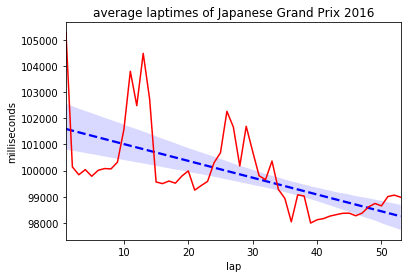

In [7]:
# Visualize the laptimes of an individual race
# Here we select a race to visualize
plot_raceID = random.choice(np.unique(laptimes_race_df['raceId']))

sns.regplot(x = 'lap'
            , y = 'milliseconds'
            , data = laptimes_race_df[laptimes_race_df['raceId'] == plot_raceID]
            , scatter = False
            , line_kws={'color' : 'blue',
                       'ls' : '--'}
           )
sns.lineplot(x = 'lap'
            , y = 'milliseconds'
            , data = laptimes_race_df[laptimes_race_df['raceId'] == plot_raceID]
            , color = 'red')\
.set_title("average laptimes of {}".format(laptimes_race_df['race'][laptimes_race_df['raceId'] == plot_raceID].iloc[0]))

Text(0.5, 1.0, 'average laptimes of all races')

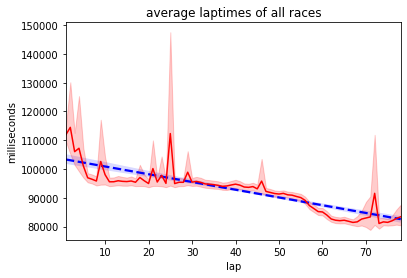

In [8]:
sns.regplot(x = 'lap'
            , y = 'milliseconds'
            , data = laptimes_race_df
            , scatter = False
            , line_kws={'color' : 'blue',
                       'ls' : '--'}
           )
sns.lineplot(x = 'lap'
            , y = 'milliseconds'
            , data = laptimes_race_df
            , color = 'red')\
.set_title("average laptimes of all races")

In [9]:
# From this plot we can see that most of the times the laptimes
# should be going down
# we will check with a regression whether that is indeed the case
# Here X will be the lapnumber, and Y will be the laptime
X = laptimes_race_df[['lap']]
y = laptimes_race_df[['milliseconds']]
reg = LinearRegression().fit(X, y)
print('Every lap is on average {0:.2f}ms faster than the previous'.format(reg.coef_[0][0]))

Every lap is on average -269.25ms faster than the previous


In [10]:
# Thus, we can see that the laptime should be going down with each lap
# Based on this info we can see that someting is going on if this is not the case
# We will make an indicator for this, indicating whether the lap was faster than the previous
laptimes_race_df['previous_round'] = laptimes_race_df['milliseconds'].shift()
laptimes_race_df['race_previous_round'] = laptimes_race_df['raceId'].shift()

conditions = [
    (laptimes_race_df['milliseconds'] < laptimes_race_df['previous_round'])
    & (laptimes_race_df['raceId'] == laptimes_race_df['race_previous_round'])
]
choices = [True]
laptimes_race_df['faster_previous'] = np.select(conditions, choices, False)                                              
laptimes_race_df.head(100)

,raceId,lap,milliseconds,race,previous_round,race_previous_round,faster_previous
0,1,1,114684.421053,Australian Grand Prix 2009,NaN,NaN,False
1,1,2,94311.894737,Australian Grand Prix 2009,114684.421053,1.0,True
2,1,3,92195.842105,Australian Grand Prix 2009,94311.894737,1.0,True
3,1,4,91353.947368,Australian Grand Prix 2009,92195.842105,1.0,True
4,1,5,90935.947368,Australian Grand Prix 2009,91353.947368,1.0,True
5,1,6,90785.368421,Australian Grand Prix 2009,90935.947368,1.0,True
6,1,7,90608.842105,Australian Grand Prix 2009,90785.368421,1.0,True
7,1,8,90957.789474,Australian Grand Prix 2009,90608.842105,1.0,False
8,1,9,92478.368421,Australian Grand Prix 2009,90957.789474,1.0,False
9,1,10,94215.578947,Australian Grand Prix 2009,92478.368421,1.0,False


We now have an indicator to show whether this lap was faster than the previous lap. However, there are multiple reasons why a lap can be slower. Such as: pit-stops, rain, traffic etc.
Therefore we want to have more conditions, and we will continue with our next hypothesis:
There will be no overtaking during a safety-car